## Worksheet + Suggested Solver

This worksheet follows a similar setup as the Problem 1 worksheet. Additionally, I have added a few suggestions on how to solve the problem.

**Note: This is only a suggested way of solving the problem. This solution is in no way complete and needs significant improvements, something we hope the competition participants will be able to do.**

**Step 1.** First convert all features into objective features - this makes modeling easier. To do this, assign a numeric value to every string. For example ```'F13': {'DB1': 4, 'DB2': 2, 'DB3': 0, 'DB4': 3, 'DB5': 1}```

**Step 2.** Identify which Quality features are important. We can do this either by 
1. Find correlation between quality Qi and end of period TRR
2. benchmark returns for every period as wi`*`Ri and break end of period TRR into three buckets: over perform index(TRR>wi`*`Ri), under perform index, +ve(TRR<wi`*`Ri, TRR>0), underperform index -ve (TRR<wi`*`Ri, TRR<0). Create a target variable `Y` and assign the following values: over perform index: 1 under perform index but +ve return: 0 underperform index and -ve return: -1. Find correlation between quality Qi and Y

**Step 3.** (Optional) Train a model which uses the selected Quality features to predict which bucket the performance will be in, use F to predict `Y`. Train a few models to check which one is the best.

**Step 4.** Define a new optimization objective function as wt`*`Qi(or Ypred) - transaction costs (We want as much weight as possible to be assigned to highest bucket). If using Ypred, run a model that first uses all the features (obviously not TRR!) to generate Ypred. Finally choose an optimizer to maximize this reward while meeting constraints.

Below is a simple implementation of this model. Suggested improvements could be:
1. Break performance into more granular buckets
2. Use a better training mechanism to predict Y (or more feature engineering before predictions
3. Define a better optimization objective function
4. Use a better optimization method


In [1]:
import pandas as pd
import numpy as np
import os.path
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

In [20]:
#### LOAD THE HELPER FUNCTIONS BELOW####
#### IMPORTANT: DONOT change these functions or your final submission will not evaluate correctly###

## This downloads your datafile, Do not change this function
def downloadFile(dataSetId):
      fileName = '%s.csv' % (dataSetId)
      url = 'https://s3.us-east-2.amazonaws.com/qq-data/qq8p2/' + fileName

      response = urlopen(url)
      status = response.getcode()
      if status == 200:
          print('Downloading the dataset %s' % (fileName))
          with open(fileName, 'w') as f:
              f.write(response.read().decode('utf8'))
          return True
      else:
          logError('File not found. Please ensure you are working with correct data set Id')
          return False


In [3]:
## This calculates the reward, Do not change this function
def getReward(wt, wt_1, ri, l, k):
    if (ri is None) or (wt is None):
        port_returns.append(0)
        sharpe_ratio.append(0)
        port_volatility.append(0)
        reward = 0
    else:
        ri.fillna(0, inplace=True)
        returns = np.dot(wt, ri)
        port_returns.append(returns)
        downside_returns = [x for x in port_returns if x < 0]
        volatility = np.std(downside_returns) #np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = np.sqrt(12)*np.mean(port_returns) / volatility if volatility!=0 else 0
        sharpe_ratio.append(sharpe)
        port_volatility.append(volatility)
        if (wt_1 is None):
            phi = 0
        else:
            ix = wt.index | wt_1.index
            tn = wt.reindex(ix) - wt_1.reindex(ix)
            tn[tn.isnull()&tn.index.isin(wt.index)] = wt
            tn[tn.isnull()&tn.index.isin(wt_1.index)] = -wt_1
            phi = k*tn.abs().sum()
        reward = returns - l*volatility - phi
#         print('returns, volatility, phi, sharpe, reward')
#         print(returns, volatility, phi, sharpe, reward)
    return reward

## Do not change this function, this verifies if all constraints are met
def checkConstraints(wt, wt_1, wi, Dt, St, Qt, g, U, t, T, P, delta, chi, eta):
    violated = False
    tol = 0.009
    if np.abs(wt.sum()-1)>tol:
        print(wt.sum())
        print("Fully Invested Constraint Violated: Sum of weights is not 1")
        violated = True
    div_constraint = np.maximum(g, 1/float(Qt.sum()))
    if (wt.abs()-div_constraint>tol).any():
        print(wt[(wt.abs()-div_constraint>tol)])
        print("Diversification Constraint Violated: All weights are not less than parameter %.2f"%div_constraint )
        violated = True
    if wt_1 is None:
        turnover = 0
    else:
        ix = wt.index | wt_1.index
        tn = wt.reindex(ix) - wt_1.reindex(ix)
        tn[tn.isnull()&tn.index.isin(wt.index)] = wt
        tn[tn.isnull()&tn.index.isin(wt_1.index)] = -wt_1
        turnover = (tn).abs().sum()/2
    turnover_list.append(turnover)
    if (np.sum(turnover_list[-12:])>U):
        print("%0.2f Turnover Constraint Violated: Turnover Limit exceeded"%np.sum(turnover_list[-12:]))
        violated = True
    if (wt<t).any():
        print("Shortsell Constraint Violated: all weights are not greater than parameter t")
        violated = True
    if wt[wt<0].sum()<T:
        print("Max Shortsell Constraint Violated: sum of all weights are not greater than parameter T")
        violated = True
    if wt[wt!=0].count() < np.minimum(P, len(wt)):
        print("Min number of positions Constraint Violated: count of all weights <>0 %i are not greater than parameter P%i"%(wt[wt!=0].count(), np.minimum(P, len(wt))))
        violated = True
    if np.abs((wt*Dt).sum()/ (wi*Dt).sum()  - 1) - delta > tol:
        print("Duration Constraint Violated: wt*Dt/ wi*Dt %.2f is greater than parameter delta"%((wt*Dt).sum()/ (wi*Dt).sum()))
        violated = True
    if np.abs((wt*St).sum()/ (wi*St).sum() -1) - chi > tol:
        print("Spread Constraint Violated: wt*St/ wi*St %.2f is greater than parameter chi"%((wt*St).sum()/ (wi*St).sum()))
        violated = True
    if (wt*(1-Qt)).abs().sum()>tol:
        print("Qualification Constraint Violated: wt*(1-qt) is not zero %.2f"%(wt*(1-Qt)).abs().sum())
        violated = True
#     if returns - Rlow/ volatility <= np.sqrt(1-eta):
#         print("Max Risk probability Constraint Violated: returns - Rlow/ volatility <= np.sqrt(1-eta)")
            
    return violated

## Do not change this function, this verifies if final constraints are met
def checkFinalConstraints(Rmin, volmax):
    violated = False
    if np.sum(port_returns)<Rmin:
        print("Total Return Constraint Violated: Total Return is less than Index Return")
        violated = True
    if port_volatility[-1]>volmax:
        print("Volatility Constraint Violated: Vol is higher than Index Vol")
        violated = True
    if sharpe_ratio[-1]<Rmin/volmax:
        print("Sharpe Ratio Constraint Violated: SR is less than Index SR")
        violated = True
        return violated

In [4]:
def getSymbolsToTrade():
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
    
    return 'G5'

In [6]:
index = getSymbolsToTrade()
### This is the file with all the features. You can use this for analysis and training
if not os.path.isfile('%s.csv'%index):
    downloadFile('%s'%index)
### This is the file with all the features but no TRR. This will be used for evaluation
if not os.path.isfile('%s_noTRR.csv'%index):
    downloadFile(index)
### This is the file with TRR. If you want to use TRR in actual logic, read from this file
if not os.path.isfile('%s_TRR.csv'%index):
    downloadFile('%s_TRR'%index)
idx_data = pd.read_csv('%s.csv'%index, index_col='TimeStamp')
idx_data.sort_index(axis=0, level=None, ascending=True, inplace=True)
idx_data_noTRR = pd.read_csv('%s_noTRR.csv'%index, index_col='TimeStamp')
idx_data_noTRR.sort_index(axis=0, level=None, ascending=True, inplace=True)
idx_data_TRR = pd.read_csv('%s_TRR.csv'%index, index_col='TimeStamp')
idx_data_TRR.sort_index(axis=0, level=None, ascending=True, inplace=True)
print(idx_data.shape)
idx_data=idx_data[~idx_data.duplicated()]
print(idx_data.shape)
print("Data Column Names:")
print(idx_data.columns)
print(index, idx_data.index[0], idx_data.index[-1])
print(idx_data.head(10))

(100225, 34)
(100225, 34)
Data Column Names:
Index([u'AssetGroup', u'Identifier', u'F2', u'F3', u'F4', u'F5', u'q', u'F7',
       u'F8', u'd', u'S', u'F11', u'F12', u'F13', u'F14', u'F15', u'F16',
       u'F17', u'wI', u'F19', u'TRR', u'ERR', u'Q1', u'Q2', u'Q3', u'Q4',
       u'Q5', u'Q6', u'Q7', u'Q8', u'Q9', u'Q10', u'Q11', u'Q12'],
      dtype='object')
('G5', '1998-12-31', '2018-11-30')
           AssetGroup Identifier        F2                     F3  \
TimeStamp                                                           
1998-12-31         G5   2157d781  7842ffa0          Capital Goods   
1998-12-31         G5   9a809873  ea94ba48         Basic Industry   
1998-12-31         G5   d6d61ada  bb0da828     Telecommunications   
1998-12-31         G5   85524178  fd2492ce     Telecommunications   
1998-12-31         G5   7b851467  dff84866                  Media   
1998-12-31         G5   364db56c  dff84866                  Media   
1998-12-31         G5   0e89b884  cc236bf2     Teleco

## Suggested Solver

Step 1. convert all features into objective features

In [7]:
for c in idx_data.columns:
    if idx_data[c].dtype==object:
        print(c, idx_data[c].dtype)

('AssetGroup', dtype('O'))
('Identifier', dtype('O'))
('F2', dtype('O'))
('F3', dtype('O'))
('F4', dtype('O'))
('F7', dtype('O'))
('F12', dtype('O'))
('F13', dtype('O'))


In [8]:
listf = ['F3', 'F4', 'F7', 'F12', 'F13']
feature_dict ={}
for feature in listf:    
    fs = idx_data[feature].unique()
    f_dict = {}
    count = 0
    for f in fs:
        idx_data[feature][idx_data[feature]==f] = count
        f_dict[f] = count
        count = count+1
    feature_dict[feature] = f_dict

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Step 2. Type 1: Create X and Y, find correlation between different Quality Features and TRR**

In [9]:
X = idx_data.copy()

X['NAs'] = X.isnull().sum(axis=1)
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(-50, inplace=True)
X['Timestamp'] = X.index
X.set_index(X.index+'-'+X['Identifier'], inplace=True)
# del X['AssetGroup']
# del X['Identifier']
# del X['F2']

In [10]:
Y = idx_data_TRR.copy()
Y_shifted = Y.copy()

z = (pd.to_datetime(Y.index) + pd.DateOffset(months=-1)).to_period('M').to_timestamp('M')
Y_shifted.set_index(pd.Series(z.format()), inplace=True)
Y_shifted['Timestamp'] = Y_shifted.index
Y_shifted.set_index(Y_shifted.index+'-'+Y_shifted['Identifier'], inplace=True)

We have shown a few ways of looking at correlation and identifying which Quality features are important. Feel free to innovate here. You might also find a combination of Quality features works better than any one singal feature

           Q1       TRR
Q1   1.000000 -0.008695
TRR -0.008695  1.000000
PointbiserialrResult(correlation=0.0027527891479208876, pvalue=0.38349325889512265)
KendalltauResult(correlation=-0.008695314921208308, pvalue=0.00010676406963573791)


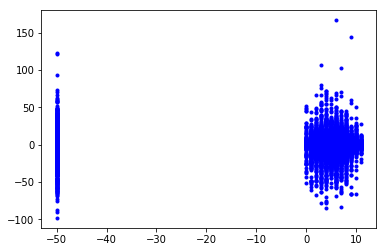

           Q2       TRR
Q2   1.000000 -0.004335
TRR -0.004335  1.000000
PointbiserialrResult(correlation=0.0003016633557224364, pvalue=0.923917373800854)
KendalltauResult(correlation=-0.004334907253020449, pvalue=0.07673695148777131)


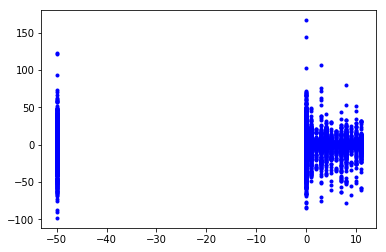

           Q3       TRR
Q3   1.000000 -0.014816
TRR -0.014816  1.000000
PointbiserialrResult(correlation=0.006030128500498521, pvalue=0.05625800761647412)
KendalltauResult(correlation=-0.014815955219890483, pvalue=2.37312304404191e-10)


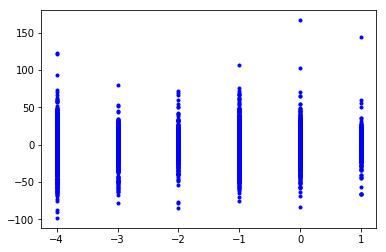

          Q4      TRR
Q4   1.00000 -0.01079
TRR -0.01079  1.00000
PointbiserialrResult(correlation=0.003169236625173372, pvalue=0.3157077115778915)
KendalltauResult(correlation=-0.01079011505147175, pvalue=1.1399507475953685e-05)


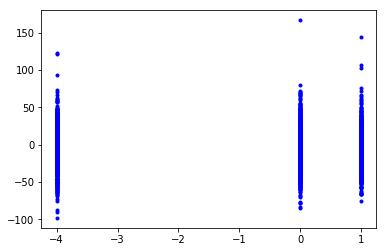

           Q5       TRR
Q5   1.000000  0.015005
TRR  0.015005  1.000000
PointbiserialrResult(correlation=0.002673592218621988, pvalue=0.39732648027656814)
KendalltauResult(correlation=0.015005020466598342, pvalue=2.4955720962960198e-11)


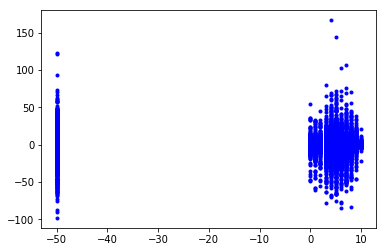

          Q6      TRR
Q6   1.00000 -0.02758
TRR -0.02758  1.00000
PointbiserialrResult(correlation=-0.00015266730481974588, pvalue=0.9614521939026381)
KendalltauResult(correlation=-0.02757973513083577, pvalue=3.368126762377064e-33)


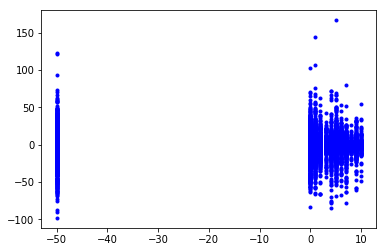

           Q7       TRR
Q7   1.000000  0.009011
TRR  0.009011  1.000000
PointbiserialrResult(correlation=0.0036609408790607197, pvalue=0.24646341831416516)
KendalltauResult(correlation=0.009010820629037734, pvalue=0.00022340911013409034)


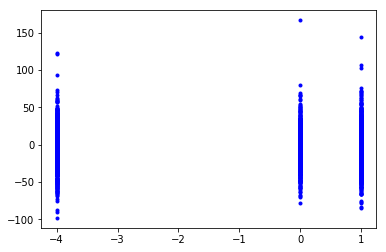

           Q8       TRR
Q8   1.000000 -0.011024
TRR -0.011024  1.000000
PointbiserialrResult(correlation=0.0014478378125429672, pvalue=0.6466968207870314)
KendalltauResult(correlation=-0.011024036236065807, pvalue=1.2922326778605414e-06)


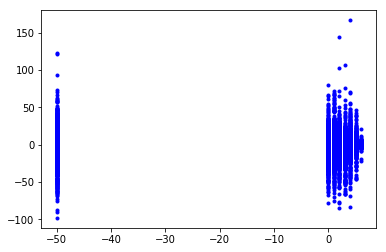

           Q9       TRR
Q9   1.000000 -0.003567
TRR -0.003567  1.000000
PointbiserialrResult(correlation=0.001304198989420714, pvalue=0.6796925748612721)
KendalltauResult(correlation=-0.003566958796841274, pvalue=0.12861420475015037)


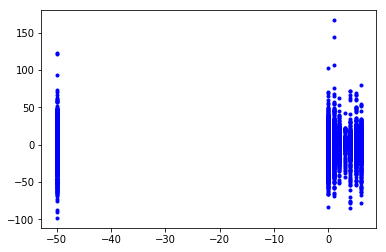

          Q10       TRR
Q10  1.000000 -0.003742
TRR -0.003742  1.000000
PointbiserialrResult(correlation=0.003101417824940488, pvalue=0.3261750943642888)
KendalltauResult(correlation=-0.0037424939749724543, pvalue=0.13090601615096725)


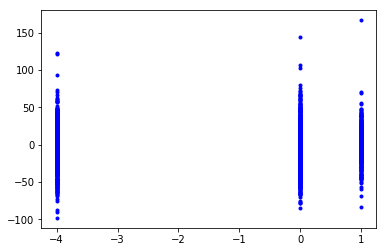

          Q11       TRR
Q11  1.000000 -0.011831
TRR -0.011831  1.000000
PointbiserialrResult(correlation=0.008265412468510043, pvalue=0.008878334721771583)
KendalltauResult(correlation=-0.011831073511613652, pvalue=5.37694013840849e-07)


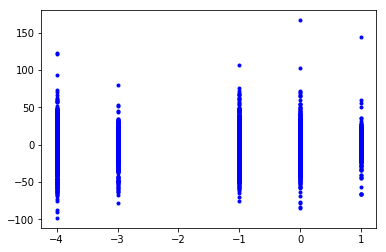

          Q12       TRR
Q12  1.000000  0.011697
TRR  0.011697  1.000000
PointbiserialrResult(correlation=0.0033995662818112585, pvalue=0.28182186866222314)
KendalltauResult(correlation=0.011697067757710247, pvalue=4.775527046468461e-07)


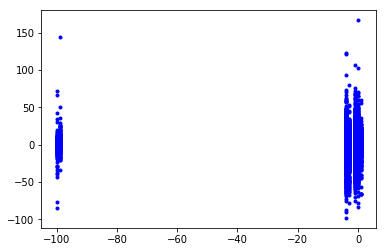

In [12]:
from matplotlib import pyplot as plt
import scipy
for i in range(12):
    temp_df = pd.DataFrame(X['Q%s'%(i+1)], index = X.index, columns=['Q%s'%(i+1), 'TRR'])
    temp_df['TRR'] = X['TRR']
    print(temp_df.corr(method='kendall'))
    print(scipy.stats.pointbiserialr(temp_df['Q%s'%(i+1)], temp_df['TRR']))
    print(scipy.stats.kendalltau(temp_df['Q%s'%(i+1)], temp_df['TRR']))
#     print(np.corrcoef(temp_df['Q%s'%(i+1)], temp_df['TRR']))
    plt.plot(temp_df['Q%s'%(i+1)], temp_df['TRR'], '.b')
    plt.show()

#### Step 2. Type 2: Break end period TRR into three buckets: over perform index, under perform index, +ve, underperform index -ve
Create a target variable 'Y' and assign the following values:
over perform index: 1
under perform index but +ve return: 0
underperform index and -ve return: -1

In [13]:
dates = idx_data.index.unique()
idx_returns = pd.Series(0.0,index=dates)
counter=0
new_idx_data = pd.DataFrame(columns=idx_data.columns)
while counter < len(dates):
    date = dates[counter]
    date_data = idx_data[idx_data.index == date]
    
    ## get all the identifiers for a date
    
    date_data.set_index( date_data['Identifier'], inplace=True)
    date_data = date_data[~date_data.index.duplicated()]
    
    wi = pd.Series(date_data['wI']/100, index = date_data['Identifier'])
    ri = pd.Series(date_data['TRR'], index = date_data['Identifier'])
    idx_returns[date]=np.dot(wi, ri)
    
    date_data.loc[date_data['TRR']<idx_returns[date], 'Y'] = 0
    date_data.loc[date_data['TRR']<0, 'Y'] = -1
    date_data.loc[date_data['TRR']>=idx_returns[date], 'Y'] = 1
    new_idx_data = new_idx_data.append(date_data)
    counter = counter+1


Now find correlation between different Quality Features and Y

In [14]:
X = new_idx_data.copy()

X['NAs'] = X.isnull().sum(axis=1)
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(-50, inplace=True)
X['Timestamp'] = X.index
X.set_index(X.index+'-'+X['Identifier'], inplace=True)

I'm calculating a few different types of correlation, some more suited to discrete variables. I'm also printing the count of each value of Y in different Q bins

Q1     Y   
-50.0  -1.0     6799
        0.0     6238
        1.0    14009
 0.0   -1.0       64
        0.0       37
        1.0      134
 1.0   -1.0      372
        0.0      217
        1.0      541
 2.0   -1.0      519
        0.0      308
        1.0     1024
 3.0   -1.0      994
        0.0      731
        1.0     1751
 4.0   -1.0     1516
        0.0     1197
        1.0     3147
 5.0   -1.0     2558
        0.0     2157
        1.0     5133
 6.0   -1.0     3304
        0.0     3172
        1.0     6753
 7.0   -1.0     3256
        0.0     3123
        1.0     6931
 8.0   -1.0     2777
        0.0     2890
        1.0     6036
 9.0   -1.0     1725
        0.0     1799
        1.0     4013
 10.0  -1.0      870
        0.0      991
        1.0     2096
 11.0  -1.0      224
        0.0      230
        1.0      589
dtype: int64
         Q1        Y
Q1  1.00000  0.01034
Y   0.01034  1.00000
PointbiserialrResult(correlation=0.004835028904735292, pvalue=0.12584865496135775)
Kendalltau

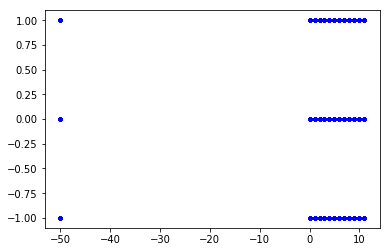

Q2     Y   
-50.0  -1.0     6386
        0.0     5810
        1.0    13098
 0.0   -1.0    15280
        0.0    14226
        1.0    32148
 1.0   -1.0      895
        0.0      856
        1.0     1967
 2.0   -1.0      198
        0.0      217
        1.0      373
 3.0   -1.0      402
        0.0      351
        1.0      808
 4.0   -1.0      320
        0.0      263
        1.0      731
 5.0   -1.0      108
        0.0       80
        1.0      221
 6.0   -1.0       95
        0.0      124
        1.0      234
 7.0   -1.0      248
        0.0      198
        1.0      450
 8.0   -1.0      402
        0.0      364
        1.0      768
 9.0   -1.0      119
        0.0       79
        1.0      220
 10.0  -1.0      112
        0.0       94
        1.0      228
 11.0  -1.0      413
        0.0      428
        1.0      911
dtype: int64
          Q2         Y
Q2  1.000000  0.002471
Y   0.002471  1.000000
PointbiserialrResult(correlation=0.003802370343786636, pvalue=0.22868375610256703)
Kend

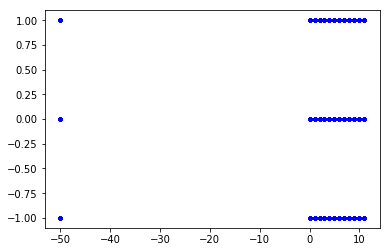

Q3  Y   
-4  -1.0     6386
     0.0     5810
     1.0    13098
-3  -1.0     1497
     0.0     1367
     1.0     3032
-2  -1.0      858
     0.0      815
     1.0     1911
-1  -1.0     3048
     0.0     1963
     1.0     5682
 0  -1.0     9345
     0.0     9025
     1.0    19486
 1  -1.0     3844
     0.0     4110
     1.0     8948
dtype: int64
          Q3         Y
Q3  1.000000  0.008651
Y   0.008651  1.000000
PointbiserialrResult(correlation=0.008907031096731438, pvalue=0.004804786094771148)
KendalltauResult(correlation=0.008650893202363931, pvalue=0.0014772233871811007)


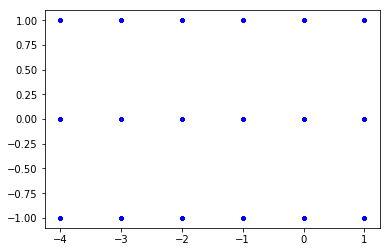

Q4  Y   
-4  -1.0     6386
     0.0     5810
     1.0    13098
 0  -1.0     5229
     0.0     3976
     1.0    10185
 1  -1.0    13363
     0.0    13304
     1.0    28874
dtype: int64
          Q4         Y
Q4  1.000000  0.006428
Y   0.006428  1.000000
PointbiserialrResult(correlation=0.005929789770671072, pvalue=0.06048169562039384)
KendalltauResult(correlation=0.0064276260658498495, pvalue=0.024642782833813753)


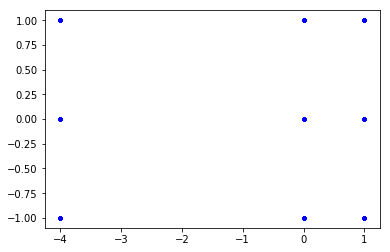

Q5     Y   
-50.0  -1.0     6386
        0.0     5810
        1.0    13098
 0.0   -1.0      343
        0.0      160
        1.0      560
 1.0   -1.0     1001
        0.0      504
        1.0     1627
 2.0   -1.0     1174
        0.0      679
        1.0     1944
 3.0   -1.0     1788
        0.0     1517
        1.0     3751
 4.0   -1.0     3473
        0.0     3036
        1.0     7429
 5.0   -1.0     4181
        0.0     4088
        1.0     9179
 6.0   -1.0     2980
        0.0     3303
        1.0     6394
 7.0   -1.0     1887
        0.0     1936
        1.0     3955
 8.0   -1.0     1287
        0.0     1396
        1.0     2927
 9.0   -1.0      440
        0.0      602
        1.0     1176
 10.0  -1.0       38
        0.0       59
        1.0      117
dtype: int64
          Q5         Y
Q5  1.000000  0.007146
Y   0.007146  1.000000
PointbiserialrResult(correlation=0.005367271741369326, pvalue=0.08928531779310661)
KendalltauResult(correlation=0.007145927713282361, pvalue=0.0063033

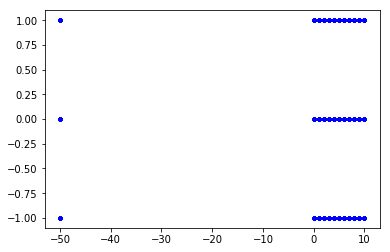

Q6     Y   
-50.0  -1.0     6386
        0.0     5810
        1.0    13098
 0.0   -1.0     6986
        0.0     7431
        1.0    15552
 1.0   -1.0     4686
        0.0     4633
        1.0    10065
 2.0   -1.0      953
        0.0      902
        1.0     2142
 3.0   -1.0      427
        0.0      597
        1.0      869
 4.0   -1.0     1767
        0.0     1080
        1.0     3452
 5.0   -1.0     2071
        0.0     1211
        1.0     3666
 6.0   -1.0      554
        0.0      536
        1.0     1146
 7.0   -1.0      572
        0.0      483
        1.0     1074
 8.0   -1.0      153
        0.0      100
        1.0      291
 9.0   -1.0      300
        0.0      234
        1.0      595
 10.0  -1.0      123
        0.0       73
        1.0      207
dtype: int64
          Q6         Y
Q6  1.000000 -0.003049
Y  -0.003049  1.000000
PointbiserialrResult(correlation=0.002589497189013045, pvalue=0.41233995330055084)
KendalltauResult(correlation=-0.0030488894539285345, pvalue=0.25405

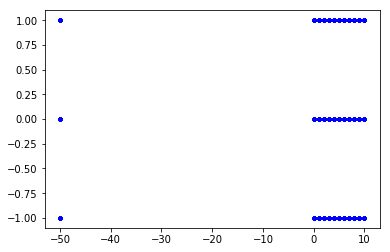

Q7  Y   
-4  -1.0     6386
     0.0     5810
     1.0    13098
 0  -1.0     7779
     0.0     5896
     1.0    15311
 1  -1.0    10813
     0.0    11384
     1.0    23748
dtype: int64
          Q7         Y
Q7  1.000000  0.005877
Y   0.005877  1.000000
PointbiserialrResult(correlation=0.006217378767400093, pvalue=0.04903204662891398)
KendalltauResult(correlation=0.00587738443922451, pvalue=0.038534317858428306)


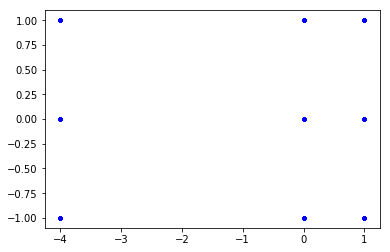

Q8     Y   
-50.0  -1.0     6386
        0.0     5810
        1.0    13098
 0.0   -1.0     2899
        0.0     2546
        1.0     6144
 1.0   -1.0     5006
        0.0     4467
        1.0    10370
 2.0   -1.0     4816
        0.0     4586
        1.0    10040
 3.0   -1.0     2667
        0.0     2433
        1.0     5288
 4.0   -1.0     2139
        0.0     1995
        1.0     4613
 5.0   -1.0      978
        0.0     1148
        1.0     2369
 6.0   -1.0       87
        0.0      105
        1.0      235
dtype: int64
          Q8         Y
Q8  1.000000  0.002816
Y   0.002816  1.000000
PointbiserialrResult(correlation=0.004292941822946548, pvalue=0.1741265955820151)
KendalltauResult(correlation=0.0028159211857779645, pvalue=0.28788771698702253)


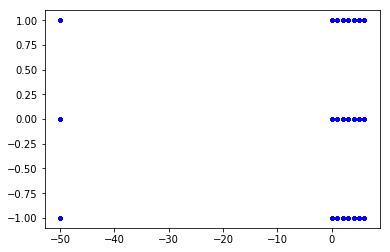

Q9     Y   
-50.0  -1.0     6386
        0.0     5810
        1.0    13098
 0.0   -1.0     8590
        0.0     8270
        1.0    18622
 1.0   -1.0     6448
        0.0     5728
        1.0    12804
 2.0   -1.0      647
        0.0      621
        1.0     1412
 3.0   -1.0      167
        0.0      264
        1.0      447
 4.0   -1.0      618
        0.0      616
        1.0     1416
 5.0   -1.0      736
        0.0      560
        1.0     1631
 6.0   -1.0     1386
        0.0     1221
        1.0     2727
dtype: int64
          Q9         Y
Q9  1.000000 -0.000258
Y  -0.000258  1.000000
PointbiserialrResult(correlation=0.003934947720340999, pvalue=0.21286423080821004)
KendalltauResult(correlation=-0.0002575507657834666, pvalue=0.9248696126726407)


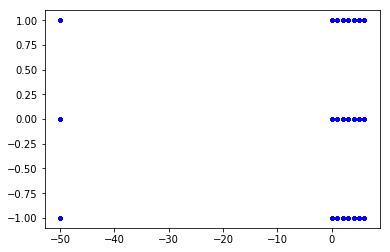

Q10  Y   
-4   -1.0     6386
      0.0     5810
      1.0    13098
 0   -1.0    15388
      0.0    14032
      1.0    31842
 1   -1.0     3204
      0.0     3248
      1.0     7217
dtype: int64
          Q10         Y
Q10  1.000000  0.007146
Y    0.007146  1.000000
PointbiserialrResult(correlation=0.005795310897166705, pvalue=0.06655144200328762)
KendalltauResult(correlation=0.007145792605873414, pvalue=0.013180975613905507)


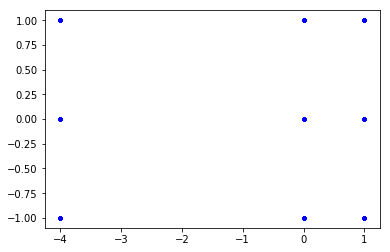

Q11  Y   
-4   -1.0     6386
      0.0     5810
      1.0    13098
-3   -1.0     1497
      0.0     1367
      1.0     3032
-1   -1.0     3048
      0.0     1963
      1.0     5682
 0   -1.0    10203
      0.0     9840
      1.0    21397
 1   -1.0     3844
      0.0     4110
      1.0     8948
dtype: int64
          Q11         Y
Q11  1.000000  0.010042
Y    0.010042  1.000000
PointbiserialrResult(correlation=0.009903727801678808, pvalue=0.0017162412218094134)
KendalltauResult(correlation=0.010042461977862007, pvalue=0.0002555174705541117)


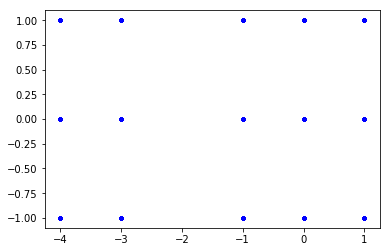

Q12   Y   
-100  -1.0     1035
       0.0     1345
       1.0     1678
-99   -1.0      866
       0.0     1341
       1.0     2102
-4    -1.0     6386
       0.0     5810
       1.0    13098
-3    -1.0     1497
       0.0     1367
       1.0     3032
-1    -1.0     3048
       0.0     1963
       1.0     5682
 0    -1.0     9168
       0.0     8495
       1.0    19719
 1    -1.0     2978
       0.0     2769
       1.0     6846
dtype: int64
          Q12         Y
Q12  1.000000  0.022129
Y    0.022129  1.000000
PointbiserialrResult(correlation=0.017816172830819647, pvalue=1.693794095830175e-08)
KendalltauResult(correlation=0.02212890545500404, pvalue=2.6799617834794325e-16)


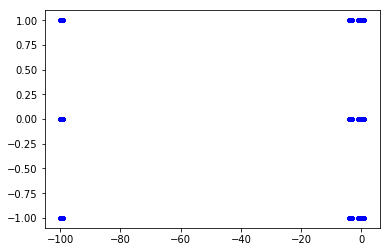

In [15]:

for i in range(12):
    temp_df = pd.DataFrame(X['Q%s'%(i+1)], index = X.index, columns=['Q%s'%(i+1), 'Y'])
    temp_df['Y'] = X['Y']
    print(temp_df.groupby(['Q%s'%(i+1), 'Y']).size())
    print(temp_df.corr(method='kendall'))
    print(scipy.stats.pointbiserialr(temp_df['Q%s'%(i+1)], temp_df['Y']))
    print(scipy.stats.kendalltau(temp_df['Q%s'%(i+1)], temp_df['Y']))
#     print(np.corrcoef(temp_df['Q%s'%(i+1)], temp_df['TRR']))
    plt.plot(temp_df['Q%s'%(i+1)], temp_df['Y'], '.b')
    plt.show()

#### Step 3. Optional: Train a model which uses the identified features to predict which bucket the performance will be in. Train a few models to check which one is the best

In [16]:
### Here I assume Q3,Q4,Q7,Q10,Q11,Q12 are important

newX = pd.DataFrame(index = X.index, columns=[])
cnt=0
for i in [3,4,7,10,11,12]:
    newX['Q%s'%(cnt)] = X['Q%s'%(i)]
    cnt=cnt+1
y = X['Y']
# newX['NAs'] = newX.isnull().sum(axis=1)
# newX

In [17]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(newX, y, random_state = 10) 

In [18]:
 # training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 10).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

# accuracy on X_test 
accuracy = dtree_model.score(X_test, y_test) 
print accuracy

# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions)
cm

0.5179790078620745


array([[    0,    28,  6285],
       [    0,    57,  5716],
       [    1,    48, 12922]])

In [19]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(newX, y, random_state = 10) 
  
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
# from sklearn.neighbors import RadiusNeighborsClassifier
# neigh = RadiusNeighborsClassifier(radius=1.0).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors = 10, weights='distance').fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
# accuracy = neigh.score(X_test, y_test) 
print accuracy 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions)
# neigh_predictions = neigh.predict(X_test)  
# cm = confusion_matrix(y_test, neigh_predictions)
cm

0.5041704912798819


array([[  378,    90,  5845],
       [  436,   121,  5216],
       [  680,   157, 12134]])

In [29]:
### Perform PCA or CCA before training
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

transform = "cca"

if transform == "pca":
        tranformedX = PCA(n_components=2).fit_transform(newX)
elif transform == "cca":
        tranformedX = CCA(n_components=2).fit(newX, y).transform(newX)

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(tranformedX, y, random_state = 10) 

knn = KNeighborsClassifier(n_neighbors = 10, weights='distance').fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print accuracy 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions)
cm

/Library/Python/2.7/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


0.49251706110069043


array([[  158,   391,  5764],
       [  195,   390,  5188],
       [  371,   807, 11793]])

### Some other training methods

In [22]:
# # training a oneVsRestclassifier after PCA or CCA
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC
# from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import CCA

# transform == "pca"

# if transform == "pca":
#         X = PCA(n_components=2).fit_transform(X)
# elif transform == "cca":
#         X = CCA(n_components=2).fit(X, y).transform(X)

# classif = OneVsRestClassifier(SVC(kernel='linear'))
# classif.fit(X, y)

In [ ]:
# # dividing X, y into train and test data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
  
# # training a linear SVM classifier 
# from sklearn.svm import SVC 
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
# svm_predictions = svm_model_linear.predict(X_test) 
  
# # model accuracy for X_test   
# accuracy = svm_model_linear.score(X_test, y_test) 
  
# # creating a confusion matrix 
# cm = confusion_matrix(y_test, svm_predictions) 
# cm

In [23]:
# # dividing X, y into train and test data 
# X_train, X_test, y_train, y_test = train_test_split(newX, y, random_state = 10) 
  
# # training a Naive Bayes classifier 
# from sklearn.naive_bayes import GaussianNB 
# gnb = GaussianNB().fit(X_train, y_train) 
# gnb_predictions = gnb.predict(X_test) 
  
# # accuracy on X_test 
# accuracy = gnb.score(X_test, y_test) 
# print accuracy 
  
# # creating a confusion matrix 
# cm = confusion_matrix(y_test, gnb_predictions) 
# cm

In [24]:
# ### Taking ensemble of all three

# y_avg = (gnb_predictions+knn_predictions+dtree_predictions)/3
# y_avg = [1 if x>0.5 else x for x in y_avg]
# y_avg = [-1 if x<-0.5 else x for x in y_avg]
# y_avg = [0 if (x>=-0.5)and(x<=0.5) else x for x in y_avg]
# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_test, y_avg))
# cm = confusion_matrix(y_test, y_avg) 
# cm


#### Step 4. Define a new optimization objective function as either 
1. wt*predictedbucketValue - transaction costs (We want as much weight as possible to be assigned to highest bucket)
OR
2. wt*Qi - transaction costs (We want as much weight as possible to be assigned to best quality bond, where Qi is the identified quality with highest relation to TRR/Y)
Train an optimizer to maximize this reward while meeting constraints

In [30]:
#     ### In this sample case, I am using scipy.optimize 
from scipy.optimize import minimize
# import cvxpy as cp

In [31]:
## Here I define my objective function 

class CustomFeatures():
    
    def newFeature1(self, wt, wt_1, ri, k):
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
        ri.fillna(0, inplace=True)
        returns = np.dot(wt, ri)
#         volatility = np.std(port_returns) #np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        weights = pd.Series(wt, index = ri.index)
    
        if (wt_1 is None):
            phi = 0
        else:
            ix = weights.index | wt_1.index
            tn = weights.reindex(ix) - wt_1.reindex(ix)
            tn[tn.isnull()&tn.index.isin(weights.index)] = weights
            tn[tn.isnull()&tn.index.isin(wt_1.index)] = -wt_1
            phi = k*tn.abs().sum()
        reward = -(returns - phi)
        return reward

** Note how I have simplified one of the constraints below. The constraint (wt*(1-Qt[Qt==1])).sum() = 0 basically mmeans only assign weights only where Qt==1. I set allowed bonds as allowed = Qt[Qt==1].index. This takes care of the constraint, and remove the constraint to make optimization easy**

Other simplifications could be to only allow bonds where d == (wi*Dt).sum() +/- (delta + eps) or s = (wi*St).sum() +/- (chi + eps), eps =10%. i.e. only allow bonds that are a small fraction more than than the index to meet the delta and chi constraint

Rest of the steps follow the same as problem 1

In [37]:
def getWeights(identifiers, reward, wi, Dt, St, Qt, g, U, t, T, P, delta, chi, eta, df, trr, wt_1,**kwargs):
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
    
    ### Here I'm assuming Q11 is the most important Quality. Ideally this will be a mix
    ri = df['Q11']
    
    div_constraint = np.maximum(g, 1/float(Qt.sum()))
    
    allowed = Qt[Qt==1].index   ###pre=process to assign weights only where Qt==1, this takes care of last constraint automatically
    
    bounds = ((t,div_constraint),) * len(allowed) #limits on weights
    
    cons = ({'type': 'eq', 'fun': lambda wt: 1.0 - np.sum(wt)},   ##sum of weights should be 1
            {'type': 'ineq', 'args': (P, Qt,),'fun': lambda wt, P, Qt: np.count_nonzero(wt) - np.minimum(P, Qt.sum())}, ## minimum number of positions should be P
            {'type': 'ineq', 'args': (delta, wi, Dt,),'fun': lambda wt, delta, wi, Dt: delta - np.abs((wt*Dt[Qt==1]).sum()/ (wi*Dt).sum() - 1)}, # duration should be within a % of index
            {'type': 'ineq', 'args': (chi, wi, St,),'fun': lambda wt, chi, wi, St: chi - np.abs((wt*St[Qt==1]).sum()/ (wi*St).sum() - 1)}, # spread should be within a % of index
#             {'type': 'eq', 'args': (Qt,),'fun': lambda wt, Qt: (wt*(1-Qt[Qt==1])).sum()} #only trade Q==1 assets
           )
    ## optimization function is defined in custom feature
    CustomFeaturesCls = CustomFeatures()
    weights = minimize(CustomFeaturesCls.newFeature1, wi[Qt==1], args=(wt_1, ri[Qt==1], k,), method='SLSQP', bounds=bounds,constraints=cons,
                      options={'maxiter': 500, 'ftol': 1e-06, 'iprint': 1, 'disp': True})   
    print(weights.success, weights.message)
    
    w = pd.Series(0, index = date_data['Identifier'])
    w[qt==1] = pd.Series(weights.x , index = allowed) ## assets with q==1 are assigned weights, rest are zero
    print(np.sum(weights.x))
    return w

In [38]:
def getKwargs():   
    return {}

In [39]:
## Step 3: Optional: Fill in the logic to return predictions for return on asset
## This function takes in the same inputs as getWeights()

### do not change the inputs to the function. If you want any extra inputs, specify them as **kwargs
### you can lookup this tutorial on how to use **kwargs https://www.geeksforgeeks.org/args-kwargs-python/

def getPrediction(identifiers, wi, Dt, St, Qt, g, U, t, T, P, delta, chi, eta, df, trr, wt_1,**kwargs):
    ################################################
    ####   COPY FROM BELOW INTO TEMPLATE FILE   ####
    ################################################
    
    X = kwargs['df'].copy()
    del X['AssetGroup']
    del X['Identifier']
    del X['F2']
    X['NAs'] = X.isnull().sum(axis=1)
    X = X.replace([np.inf, -np.inf], np.nan)
    X.fillna(-50, inplace=True)
    y1 = knn.predict(X)
    
    ri = pd.Series(y1, index = date_data['Identifier'])
    
    return ri

Run the cells below to evaluate.
The snippet below downloads the correct dataset and lets you explore the dataset.

Note Remember TRR: Total Return at the end of the period - VERY IMPORTANT!! The snippet below enforces this. 
You can read all the features from df `idx_data_noTRR` and TRR from df `idx_data_TRR`. TRR for a certain period only becomes available after period end.

Once you are happy with your submission, copy the appropriate functions into the template file

In [40]:
# empty lists to store returns, volatility and weights of imaginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
asset_weights = []
reward_list = []
turnover_list = []
idx_returns = []

#port_returns ,port_volatility ,sharpe_ratio ,asset_weights ,reward_list ,turnover_list ,idx_returns 

#empty df to store previous period returns
ri = None

#empty dict to store values by date
dict_metrics_by_date = {}


In [43]:
### Evaluator to getweights at everytime t and calcuate reward + check if constraints are met

## specifying all the constants
counter = 0
l = 0.1
k = 0.03
g = 0.04
U = 2.5
t= 0
T = 0
P = 50
delta = 0.5
chi = 0.15
eta = 0.95

## initializing arrays
dates = idx_data_noTRR.index.unique()
wi = None

## looping over all dates
while counter < len(dates):
#     import pdb;pdb.set_trace()
    date = dates[counter]
    idx_data = idx_data_noTRR[idx_data_noTRR.index <= date]
    
    ## load all the data for a date
    date_data = idx_data[idx_data.index == date]
    
    print(index, idx_data.index[0], idx_data.index[-1])
    
    ## get all the identifiers for a date
    cusips = date_data['Identifier'].unique()
    date_data.set_index( date_data['Identifier'], inplace=True)
    
    #load last period info

    if len(idx_data_TRR[idx_data_TRR.index == date])>0:
        ri = pd.DataFrame(idx_data_TRR[idx_data_TRR.index == date]['TRR'])
        ri.set_index(idx_data_TRR[idx_data_TRR.index == date]['Identifier'], inplace=True)
        ri = ri['TRR']
        date_data['TRR'] = ri
    else:
        ri = None#pd.Series(date_data['TRR'])
        date_data['TRR'] = None

    ## old weights
    wt_1 = asset_weights[-1] if len(asset_weights)>0 else None
    wt_2 = asset_weights[-2] if len(asset_weights)>1 else None
    
    ##old index weights
    wi_t_1 = None if wi is None else wi.copy()
    
    ## calculate reward at start of time t from weights allocated at time t-1
    reward = getReward(wt_1, wt_2, ri, l, k)
    
    ## calculate index return at start of time t from weights allocated at time t-1
    if ri is None or wi_t_1 is None:
        idx_returns.append(0)
    else:
        idx_returns.append(np.dot(wi_t_1, ri))
    
    #load specific feature info for time t
    wi = pd.Series(date_data['wI']/100, index = date_data['Identifier'])
    Dt = pd.Series(date_data['d'], index = date_data['Identifier'])
    St = pd.Series(date_data['S'], index = date_data['Identifier'])
    qt = pd.Series(date_data['q'], index = date_data['Identifier'])
    
    ## get new weights
    if wt_1 is None:
        wt = wi.copy()
    else:
        wt = getWeights(cusips, reward_list[-1], wi, Dt, St, qt, g, U, t, T, P, delta, chi, eta,\
                        date_data, ri, wt_1, **getKwargs()) 

    
    ## store relevant info in their lists
    asset_weights.append(wt)
    reward_list.append(reward)
    
    ## verify if all constraints are met
    if checkConstraints(wt, wt_1, wi, Dt, St, qt, g, U, t, T, P, delta, chi, eta):
        print("ERROR!!!! weights don't meet contraints, exiting")
#         break
    
    dict_metrics_by_date[date] = {'returns': port_returns[-1],
                                  'volatility': port_volatility[-1] ,
                                  'Sharpe Ratio': sharpe_ratio[-1],
                                  'Index Returns': idx_returns[-1],
                                  'Reward': reward_list[-1],
                                  '12m turnover' : turnover_list[-1]
                                  }
    
    print(dict_metrics_by_date[date])
    dict_metrics_by_date[date]['weights'] = asset_weights[-1]
    
    counter += 1
    

## Calculate returns for last period    
if ri is not None:
    reward = getReward(wt, wt_1, ri, l, k)
    reward_list.append(reward)
    idx_returns.append(np.dot(wi, ri))
## check if contraints on total return and risk are met        
Rmin = np.sum(idx_returns)
volmax = np.std(idx_returns)
if checkFinalConstraints(Rmin, volmax):
    print("ERROR!!!! weights don't meet return/risk limit contraints, exiting")
else:
    print("Portfolio Metrics:")
    print("Total Return: %.2f"%np.sum(port_returns))
    print("Standard Deviation: %.2f"%port_volatility[-1])
    print("Sharpe Ratio: %.2f"%sharpe_ratio[-1])

('G5', '1998-12-31', '1998-12-31')
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.61881988899
            Iterations: 27
            Function evaluations: 2162
            Gradient evaluations: 23
(True, 'Optimization terminated successfully.')
0.7820265052580263
0.7820265052580263
Fully Invested Constraint Violated: Sum of weights is not 1
Duration Constraint Violated: wt*Dt/ wi*Dt 0.63 is greater than parameter delta
Spread Constraint Violated: wt*St/ wi*St 0.52 is greater than parameter chi
ERROR!!!! weights don't meet contraints, exiting
{'Index Returns': 0, '12m turnover': 0.38011006531063707, 'returns': 0, 'Reward': 0, 'Sharpe Ratio': 0, 'volatility': 0}
('G5', '1998-12-31', '1999-01-31')


/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1.81285113217
            Iterations: 34
            Function evaluations: 2906
            Gradient evaluations: 30
(False, 'Positive directional derivative for linesearch')
0.7880005095536557
0.7880005095536557
Fully Invested Constraint Violated: Sum of weights is not 1
2.60 Turnover Constraint Violated: Turnover Limit exceeded
Duration Constraint Violated: wt*Dt/ wi*Dt 0.63 is greater than parameter delta
Spread Constraint Violated: wt*St/ wi*St 0.53 is greater than parameter chi
ERROR!!!! weights don't meet contraints, exiting
{'Index Returns': -2.4817292545000003, '12m turnover': 0.20711899701312245, 'returns': -0.20943989806650898, 'Reward': -0.3183797985558618, 'Sharpe Ratio': 0.45838507055824484, 'volatility': 0.8613329657071462}
('G5', '1998-12-31', '1999-02-28')
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.41026927273
            

KeyboardInterrupt: 

In [ ]:
with open('run1','w') as data:
    data.write(str(dict_metrics_by_date))